In [2]:
import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
import numpy
from sklearn.metrics import accuracy_score

from tslearn.generators import random_walk_blobs
from tslearn.preprocessing import TimeSeriesScalerMinMax, \
    TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries
import pandas as pd
import numpy as np
import random
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesResampler

2023-04-20 18:50:44.090074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_pickle("Train.pkl")
randomlist1 = random.sample(range(0, 260), 20)

df_test1 = df.loc[df["Batch"].isin(randomlist1)]
df_train1 = df.loc[~df["Batch"].isin(randomlist1)]
df_steps1 = df_test1.loc[df_test1["CuStepNo ValueY"] != df_test1["Next_Step"]]
df_steps2 = df_train1.loc[df_train1["CuStepNo ValueY"] != df_train1["Next_Step"]]
y_train1 = df_steps2.loc[df_steps2["CuStepNo ValueY"] == 7,"DeviationID ValueY"].astype(int)
y_test1 = df_steps1.loc[df_steps1["CuStepNo ValueY"] == 7,"DeviationID ValueY"].astype(int)
X_train1 = df_train1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_test1 = df_test1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_train_step1 = []
for i in X_train1.Batch.unique():
        num = numpy.array(X_train1.loc[(X_train1["Batch"] == i)&(X_train1["CuStepNo ValueY"] == 7)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_train_step1.append(num)
X_test_step1 = []
for i in X_test1.Batch.unique():
        num = numpy.array(X_test1.loc[(X_test1["Batch"] == i)&(X_test1["CuStepNo ValueY"] == 7)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_test_step1.append(num)
length = []
for i in X_train_step1:
    length.append(len(i))
X_train_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_train_step1)
X_test_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_test_step1)
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train_s1)
X_test = scaler.transform(X_test_s1)

In [4]:
shp_clf = LearningShapelets(n_shapelets_per_size={23:10},
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=200,
                            weight_regularizer=.01,
                            max_iter=250,
                            random_state=42,
                            scale=True,
                            verbose=0)
shp_clf.fit(X_train, y_train1)

LearningShapelets(batch_size=200, max_iter=250, n_shapelets_per_size={23: 10},
                  optimizer=<keras.optimizers.adam.Adam object at 0x7fe1757a3c10>,
                  random_state=42, scale=True, weight_regularizer=0.01)

In [5]:
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test1, pred_labels))

Correct classification rate: 0.5


In [6]:
shapelets = shp_clf.shapelets_as_time_series_
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)
list1 = []
for i in range(1,24):
    list1.append(i)


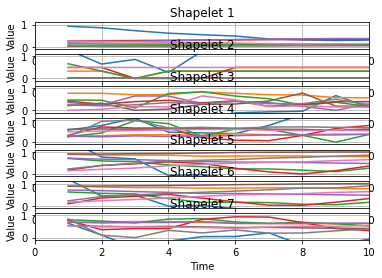

In [7]:
#make subplots
f, ax = plt.subplots(7, 1, sharey="col")
#loop through the shapelets
for i in range(0,7):
    #loop through the classes
    ax[i].plot(list1,shp_clf.shapelets_as_time_series_[0][:,i])
    for j in range(0,7):
        #get the index of the shapelet
        index = np.where(y_train1 == list1[j])
        #get the shapelet
        shapelet = shp_clf.shapelets_as_time_series_[i]
        #plot the shapelet
        ax[i].plot(list1, X_train[j][shp_clf.locate(X_train)[j][0]:shp_clf.locate(X_train)[j][0]+23][:,i])
        ax[i].set_title("Shapelet " + str(i+1))
        ax[i].set_ylabel("Value")
        ax[i].set_xlabel("Time")
        ax[i].set_xlim(0,10)
        ax[i].set_ylim(-0.1,1.1)
        ax[i].grid(True)

plt.show()


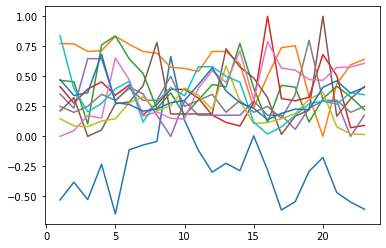

In [8]:

plt.plot(list1,shp_clf.shapelets_as_time_series_[0][:,2])
for i in range(0,10):
    plt.plot(list1, X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2],
)


In [27]:
import plotly.express as px
import plotly.graph_objects as go

# px.line(x=list1,y=shp_clf.shapelets_as_time_series_[0][:,0])
# px.line(x=list1,y=X_train[0][8:15][:,0])
#combine both plotly plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=list1, y=shp_clf.shapelets_as_time_series_[0][:,2],
                    mode='lines',
                    name='Deviation1'))
for i in range(0,10):
    fig.add_trace(go.Scatter(x=list1, y=X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2],
                        mode='lines',
                        name=f'Time Series {int(y_train1[i:i+1])}'))
fig.update_layout(title='Shapelet nr. 1',
                     xaxis_title='Time',
                        yaxis_title='Value')

SyntaxError: f-string: unmatched ')' (3517384636.py, line 14)

In [199]:
y_train1

248       1
1301      4
2350      5
3460      1
4511      6
         ..
260738    9
261846    9
262961    9
264080    9
265190    9
Name: DeviationID ValueY, Length: 231, dtype: int64

In [206]:
X_train[2][shp_clf.locate(X_train)[2][0]:shp_clf.locate(X_train)[2][0]+23][:,2]

array([0.41490522, 0.27690461, 0.39374092, 0.45354504, 0.34222911,
       0.42870617, 0.18031462, 0.26678751, 0.39098073, 0.39098073,
       0.31922563, 0.17663285, 0.11683138, 0.08647706, 0.28242442,
       1.        , 0.3146291 , 0.29623068, 0.32566968, 0.68169349,
       0.50505684, 0.07267156, 0.09107093])

In [211]:
y_train1[2:3]

2350    5
Name: DeviationID ValueY, dtype: int64

In [195]:
fig = go.Figure()

fig.add_trace(
 go.Scatter(
  x= list1,
  y= shp_clf.shapelets_as_time_series_[0][:,2],
  mode= "lines",
  name= "Deviation 1 (Normalbetrieb)"
 )
)

for i in range(0,5):
 fig.add_trace(
  go.Scatter(
   x= list1,
   y= X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2],
   mode= "lines",
   name= f"Time Series {str(i+1)}"
  )
 )

fig.update_layout(
     title= dict(text= "<b>Text<b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.955, x=0.475),
     height= 700,
     legend_title_text= "<b>Text</b>",
     legend_title_font_size= 16,
     paper_bgcolor='rgba(0,0,0,0)',
     plot_bgcolor='rgba(0,0,0,0)',
     font= dict(color= "white")
)


fig.update_yaxes(showgrid= True, ticks= "outside", showticklabels= True, zeroline= False, showline= True, gridcolor= "grey", nticks= 5)
fig.update_xaxes(showgrid= True, zeroline= False, gridcolor= "grey")

fig.show()

In [50]:
from plotly.subplots import make_subplots

In [55]:
fig.print_grid()

This is the format of your plot grid:
[ (1,1) x,y   ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]



In [161]:
for i in range (2,6):
 print(i)

2
3
4
5


In [193]:
X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2]

array([0.21158473, 0.32151292, 0.        , 0.05437351, 0.27186755,
       0.28605194, 0.42080636, 0.78251254, 0.18676118, 0.18676118,
       0.18676118, 0.18676118, 0.72932045, 0.57801733, 0.48581999,
       0.3227036 , 0.0165543 , 0.16785061, 0.21986565, 1.        ,
       0.16785669, 0.31205812, 0.41608188])

In [194]:
fig1 = make_subplots(cols= 1, rows= 5)

fig1.add_trace(
 go.Scatter(
  x= list1,
  y= shp_clf.shapelets_as_time_series_[0][:,2],
  mode= "lines",
  name= "Deviation 1 (Normalbetrieb)"
 ), 
 col= 1,
 row= 1
)

for i in range(2,6):
     fig1.add_trace(
          go.Scatter(
               x= list1,
               y= X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2],
               mode= "lines",
               name= f"Time Series {i}"
          ),
          col= 1,
          row= i
          )

fig1.update_layout(
     title= dict(text= "<b>TEXT<b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.955, x=0.475),
     height= 1000,
     width = 1000,
     legend_title_text= "<b>TEXT</b>",
     legend_title_font_size= 16,
     paper_bgcolor='rgba(0,0,0,0)',
     plot_bgcolor='rgba(0,0,0,0)',
     font= dict(color= "white")
)


for r in range(1, 6):

     if r == 5:
          fig1.update_xaxes(showgrid= True, col= 1, row= r, title_text="<b>Text</b>", title_font= dict(size= 14), gridcolor= "grey")
          fig1.update_yaxes(showgrid= True, col= 1, row= r, tickvals= [-1, -0.5, 0, 0.5, 1], ticks= "outside", showticklabels= True, zeroline= False, showline= True, gridcolor= "grey")

     elif r == 3:
          fig1.update_yaxes(showgrid= True, col= 1, row= r, title_text="<b>Text</b>", tickvals= [-1, -0.5, 0, 0.5, 1], ticks= "outside", showticklabels= True, zeroline= False, showline= True, gridcolor= "grey")
          fig1.update_xaxes(showgrid= True, col= 1, row= r, zeroline= True, gridcolor= "grey")

     else:
          fig1.update_yaxes(showgrid= True, col= 1, row= r, tickvals= [-1, -0.5, 0, 0.5, 1], ticks= "outside", showticklabels= True, zeroline= False, showline= True, gridcolor= "grey", nticks= 5)
          fig1.update_xaxes(showgrid= True, col= 1, row= r, zeroline= True, gridcolor= "grey")
     

fig1.show()

In [233]:
algos= ["NN", "ROCKET", "L. Shapelets", "Catch22"]
acc_scores = [0.7534246575342466, 0.839041095890411, 0.5993150684931506, 0.7945205479452054]

for index, algo in enumerate(algos):
 print(algo)
 print(acc_scores[index])

NN
0.7534246575342466
ROCKET
0.839041095890411
L. Shapelets
0.5993150684931506
Catch22
0.7945205479452054


In [239]:
px.colors.qualitative.swatches()

In [303]:
algos= ["NN", "ROCKET", "L. Shapelets", "Catch22"]
acc_scores = [0.7534246575342466, 0.839041095890411, 0.5993150684931506, 0.7945205479452054]
runtimes= [4.4416667, 0.2216667, 40.3233333, 92.103333]

fig = go.Figure()


for ind, algo in enumerate(algos):
   fig.add_trace(
      go.Bar(
         x= [algo],
         y= [acc_scores[ind]],
         name= f"{algo}",
         marker= dict(color= px.colors.qualitative.Prism[ind]),
         width= 0.5,
         hovertemplate= f"<b>{algo}</b><br><br>" +
         "acc_score: %{y}<br>" +
         "<extra></extra>",
         yaxis= "y1"
      )
   )

fig.add_trace(
   go.Scatter(
      x= algos,
      y= runtimes,
      name = "Runtime",
      yaxis = "y2",
      mode= "markers+lines+text",
      marker= dict(color= px.colors.qualitative.Plotly[4]),
      hovertemplate= f"<b>{algo}</b><br><br>" +
         "Min: %{y}<br>" +
         "<extra></extra>",
      #text= runtimes,
      #textposition= "top center"
      #fill= "tonexty",
   )
)

fig.update_xaxes(title_text="<b>algorithms</b>", ticks= "outside", showline= False)
fig.update_layout(
   title= dict(text= "<b>Accuracy Runtime Comparison</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475),
   legend_title_text = "<b>Classification Algorithms</b>",
   height= 800,
   xaxis= dict(linecolor= "white"), 
   yaxis1= dict(linecolor= "white", title_text="<b>accuracy</b>", ticks= "outside", showgrid= True, gridcolor= "grey", showline= False),
   yaxis2= dict(linecolor= "white", title_text="<b>runtime</b>", ticks= "outside", showgrid= False, showline= False, zeroline = False, side= "right"),
   paper_bgcolor= "rgba(0,0,0,0)", 
   plot_bgcolor= "rgba(0,0,0,0)", 
   font_color= "white")

fig.show()

In [304]:
df_roc = pd.read_csv("Ausgabe.csv")

In [305]:
df_roc

,Unnamed: 0,wahre_labels,nearestneighbour,catch22,shapelets,rocket
0,7334,False,False,0.035,0.260047,0.0
1,7643,False,False,0.155,0.019332,1.0
2,7708,False,True,0.685,0.169754,1.0
3,8251,False,True,0.470,0.184323,1.0
4,8917,True,False,0.245,0.091652,0.0
...,...,...,...,...,...,...
287,261342,False,False,0.045,0.215079,0.0
288,261541,False,False,0.000,0.056618,0.0
289,261846,False,False,0.010,0.060831,0.0
290,261918,False,False,0.055,0.267245,0.0


In [ ]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
)
fig.show()

In [306]:
from sklearn.metrics import roc_auc_score, roc_curve

In [339]:
df_roc

,Unnamed: 0,wahre_labels,nearestneighbour,catch22,shapelets,rocket
0,7334,False,False,0.035,0.260047,0.0
1,7643,False,False,0.155,0.019332,1.0
2,7708,False,True,0.685,0.169754,1.0
3,8251,False,True,0.470,0.184323,1.0
4,8917,True,False,0.245,0.091652,0.0
...,...,...,...,...,...,...
287,261342,False,False,0.045,0.215079,0.0
288,261541,False,False,0.000,0.056618,0.0
289,261846,False,False,0.010,0.060831,0.0
290,261918,False,False,0.055,0.267245,0.0


In [320]:
for classifier in df_roc.iloc[:,2:6]:
 print(df_roc[f"{classifier}"].head(1))

0    False
Name: nearestneighbour, dtype: bool
0    0.035
Name: catch22, dtype: float64
0    0.260047
Name: shapelets, dtype: float64
0    0.0
Name: rocket, dtype: float64


In [342]:
fig= go.Figure()

for classifier in df_roc.iloc[:,2:6]:

 fpr, tpr, _ = roc_curve(df_roc.wahre_labels, df_roc[f"{classifier}"])
 auc_score = roc_auc_score(df_roc.wahre_labels, df_roc[f"{classifier}"])

 fig.add_trace(
  go.Scatter(
   x= fpr,
   y= tpr,
   name= f"{classifier} (AUC= {auc_score.round(2)})",
   mode= "lines"
  )
 )

fig.add_shape(
   type= "line",
   line = dict(dash= "dash"),
   x0= 0,
   x1= 1,
   y0= 0,
   y1= 1
)

fig.update_xaxes(title_text="<b>False positive rate</b>", ticks= "outside", showline= False, gridcolor= "grey")
fig.update_layout(
   title= dict(text= "<b>ROC EVALUATION</b>", font_size= 20, xanchor= "center", yanchor= "top", y=0.935, x=0.475),
   legend_title_text = "<b>Classification Algorithms</b>",
   height= 600,
   width= 900,
   xaxis= dict(linecolor= "white"),# constrain= "domain"), 
   yaxis= dict(linecolor= "white", title_text="<b>True positive rate</b>", ticks= "outside", showgrid= True, gridcolor= "grey", showline= False),# scaleanchor="x", scaleratio=1),
   paper_bgcolor= "rgba(0,0,0,0)", 
   plot_bgcolor= "rgba(0,0,0,0)", 
   font_color= "white")

fig.show()
 